In [1]:
import torch, sys, json, os, pickle
sys.path.append("torchdrug/")
from torchdrug import data, datasets, core, models, tasks, utils
import numpy as np

In [2]:
# Some utilities 

# Load dataset
def load_from_pickle(pkl_file, name = "QM9"):
    print(f"Loading {name} dataset...")
    with open(pkl_file , "rb") as f:
        dset = pickle.load(f)
    print(f"Loaded {name} dataset.")
    return dset
# Clean dataset
def clean_dataset(dataset):
    errors = 0
    good_mols = []
    for i, mol in enumerate(dataset.data):
        if mol.stereo_atoms is not None and mol.stereo_atoms.size()[1] == 0:
            errors += 1
            mol.stereo_atoms = torch.zeros([int(mol.num_edge), 2], dtype=torch.int64)
        elif int(mol.num_edge) == 0:
            if mol.stereo_atoms is not None:
                errors += 1
                mol.stereo_atoms = torch.tensor([])
        good_mols.append(mol)
    if errors > 0:
        print("Errors found, revising dataset.")
        dataset.data = good_mols
    else:
        print("No errors found!")
    return dataset
# Molecule Graph from SMILES
def mol_graph_from_smiles(SMILES, mol_feature = None):
    mol = data.Molecule.from_smiles(SMILES, mol_feature = mol_feature)
    return mol
# Save dataset
def save_to_pickle(pkl_file, dset, name = "QM9"):
    print(f"Saving {name} dataset...")
    with open(pkl_file , "wb") as f:
        pickle.dump(dset, f)
    print(f"Saved {name} dataset to {pkl_file}.")

In [3]:
qm9 = load_from_pickle("QM9.pkl", "QM9")

Loading QM9 dataset...


KeyboardInterrupt: 

In [38]:
for i in qm9.data:
    print(i.atom_feature.size())

torch.Size([1, 67])
torch.Size([1, 67])
torch.Size([1, 67])
torch.Size([2, 67])
torch.Size([2, 67])
torch.Size([2, 67])
torch.Size([2, 67])
torch.Size([2, 67])
torch.Size([3, 67])
torch.Size([3, 67])
torch.Size([3, 67])
torch.Size([3, 67])
torch.Size([3, 67])
torch.Size([3, 67])
torch.Size([3, 67])
torch.Size([3, 67])
torch.Size([3, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([4, 67])
torch.Size([5, 67])
torch.Size([5, 67])


In [18]:
import rdkit.Chem.AllChem as Chem
SMILES = "CCO"
rdkit_mol = Chem.MolFromSmiles(SMILES)
#rdkit_mol_with_hydrogens = Chem.AddHs(rdkit_mol)
Chem.EmbedMolecule(rdkit_mol)
node_position = torch.tensor(rdkit_mol.GetConformer().GetPositions())

[14:44:53] Molecule does not have explicit Hs. Consider calling AddHs()


In [19]:
test_mol = data.Molecule.from_molecule(rdkit_mol)

In [68]:
test_mol.atom_feature

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [65]:
test_mol.edge_list

tensor([[0, 1, 0],
        [1, 0, 0],
        [1, 2, 0],
        [2, 1, 0]])

In [59]:
edges = test_mol.num_edge
feat_length = 
updated_edges = torch.zeros(size = (test_mol.edge_list))
for i, edge in enumerate(test_mol.edge_feature):
    nodes = test_mol.edge_list[i][:-1].tolist()
    n1_i, n2_i = nodes[0], nodes[1]
    n1_pos = test_mol.node_position[n1_i]
    n2_pos = test_mol.node_position[n2_i]
    distance = torch.tensor([np.linalg.norm(n1_pos - n2_pos)])
    updated_edge_feature = torch.cat((distance, test_mol.edge_feature[i])) 
    test_mol.edge_feature[i] = updated_edge_feature

RuntimeError: The expanded size of the tensor (18) must match the existing size (19) at non-singleton dimension 0.  Target sizes: [18].  Tensor sizes: [19]

In [36]:
bonds = [rdkit_mol.GetBondWithIdx(i) for i in range(rdkit_mol.GetNumBonds())]
print(bonds)
for bond in bonds:
    type = str(bond.GetBondType())
    stereo = bond.GetStereo()
    if stereo:
        _atoms = [a for a in bond.GetStereoAtoms()]
    else:
        _atoms = [0, 0]
    print(_atoms)

[<rdkit.Chem.rdchem.Bond object at 0x1479ec596510>, <rdkit.Chem.rdchem.Bond object at 0x1479ec596580>]
[0, 0]
[0, 0]


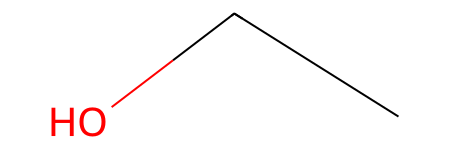

In [23]:
rdkit_mol

In [25]:
d = {}
d["b_type"] = Chem.rdchem.BondType.SINGLE
e_t = [int(d['b_type'] == x) for x in [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
                                        Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]]

In [26]:
e_t

[1, 0, 0, 0]